# Statistical Process Control (SPC) Basics

*Purpose*: 


## Setup


In [1]:
import grama as gr
import numpy as np
DF = gr.Intention()
%matplotlib inline

# Theory


(It's difficult to tell by-inspection if data are random)


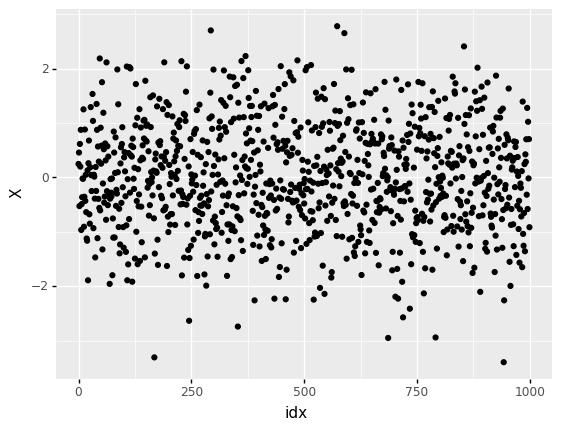

<ggplot: (8742560364093)>

In [2]:
np.random.seed(102)

mg_normal = gr.marg_mom("norm", mean=0, sd=1)
df_random = (
    gr.df_make(X=mg_normal.r(1000))
    >> gr.tf_mutate(idx=DF.index)
)

(
    df_random
    >> gr.ggplot(gr.aes("idx", "X"))
    + gr.geom_point()
)

- Without some sense of *reasonable limits*, we can't distinguish outliers from the normal highs and lows of randomness.
- Without some knowledge of the underlying random process, we cannot define reasonable limits.


Rather than do concentrated staring at random patterns, we can make some *intelligent choices* about grouping observations, and use *batch averages* to set meaningful *control limits*. These ideas combine in a *control chart*; the following plot is our first example of a control chart.

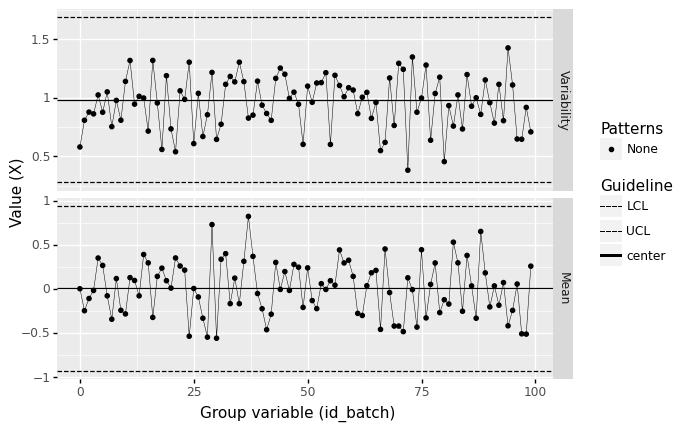

<ggplot: (8742560415190)>

In [3]:
%%capture --no-display
## NOTE: No need to edit

(
    df_random 
    ## Group observations into consecutive batches of 10
    >> gr.tf_mutate(id_batch=DF.index // 10)
    ## Construct an Xbar and S (xbs) chart
    >> gr.pt_xbs(group="id_batch", var="X")
)

From this chart, we see no outliers outside the lower control limit (LCL) or upper control limit (UCL). We also don't see any special patterns in the data. Therefore, based on this control chart, we can declare that the process is likely under *statistical control*---that it can be modeled as random.


## Batch Averages

We saw before that the *sample mean* follows the central limit theorem, which tells us about the distribution of the sample mean. Thus taking the average of multiple observations *from the same process* gives us a way to make the underlying distribution more predictable.

However, taking the average of *all* observations prevents us from determining *where* an outlier occurred: If the mean of all the data is high, was it the first observation that was large? The last one? Something in the middle?

Taking *batch averages* gives us better resolution, while still giving the advantages of the central limit theorem.


## Control limits: Confidence Intervals


## Grouping observations

(Should ideally be paired with data collection.)


### Natural batches


In [4]:
## NOTE: No need to edit
np.random.seed(101)

df_base = gr.df_make(
    sd=[0.01, 0.04, 0.01, 0.01, 0.01, 0.01],
    ma=[ "A",  "B",  "C",  "D",  "E",  "F"],
)
mg = gr.marg_mom("norm", mean=0, sd=1)

df_machines = gr.df_grid()
for i in range(df_base.shape[0]):
    df_machines = (
        df_machines
        >> gr.tf_bind_rows(
            gr.df_make(
                X=mg.r(15) * df_base.sd[i],
                id_machine=df_base.ma[i],
            )
        )
    )
# Randomly sort
df_machines = (
    df_machines
    >> gr.tf_sample(frac=1)
)


### __qX__ Naive consecutive rows

Batch the observations in `df_machines` into groups of consecutive observations, and use that grouping to construct a control chart with `gr.pt_xbs()`. Answer the questions under *observations* below.

*Hint*: The data above are in a *random* order. Keep that in mind when answering the questions below.


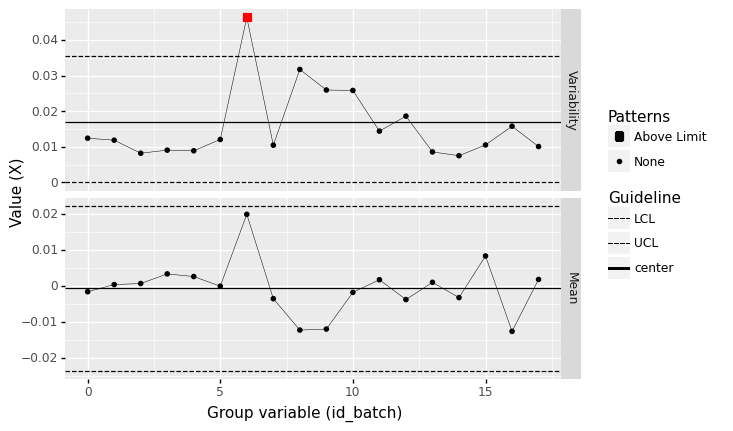

<ggplot: (8742560264159)>

In [5]:
%%capture --no-display
(
    df_machines
# solution-begin    
    >> gr.tf_mutate(id_batch=DF.index // 5)
    >> gr.pt_xbs(group="id_batch", var="X")
# solution-end    
)

*Observations*

- Based on the batch size you chose, did you find any out-of-control patterns?
  - At a batch size of `n=5` I did find one out-of-control pattern for the variability.
- If you answered "yes" to the previous question, does your group variable give you a meaningful way to determine what may have cause the out-of-control pattern?
  - No; the observations are in a random order, so consecutive groups have no particular meaning.
<!-- solution-end -->

### __qX__ Batch by machine

Construct a control chart using the machine identifier as the `group` variable. Answer the questions under *observations* below.


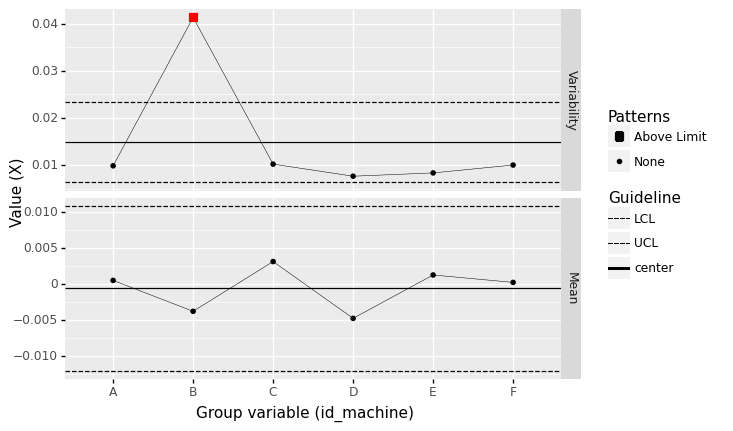

<ggplot: (8742749895259)>

In [6]:
%%capture --no-display
## TODO: Create a control chart grouped by machine
(
    df_machines
# solution-begin    
    >> gr.pt_xbs(group="id_machine", var="X")
# solution-end    
)

*Observations*

- Based on the batch size you chose, did you find any out-of-control patterns?
  - Yes, I see out-of-control variability for Machine B.
- If you answered "yes" to the previous question, does your group variable give you a meaningful way to determine what may have cause the out-of-control pattern?
  - Yes! Batching by machine gives us an obvious clue about where the out-of-control behavior occurred.
<!-- solution-end -->

### Batches in time

> A rule of thumb is to use three time periods with 20 to 25 samples of size 50 to 100 units each.

The following code simulates 45 samples, where each sample contains 50 observations. This results in `45 * 50 = 2250` observations total.


In [7]:
## NOTE: No need to edit
np.random.seed(101)

df_base = gr.df_make(
    mu=[0]*30 + list(gr.linspace(0, 0.8, 15)),
)
mg = gr.marg_mom("norm", mean=0, sd=1)

df_time = gr.df_grid()
for i in range(df_base.shape[0]):
    df_time = (
        df_time
        >> gr.tf_bind_rows(
            gr.df_make(X=mg.r(50) + df_base.mu[i])
        )
    )
# Randomly sort
df_time = (
    df_time
    >> gr.tf_mutate(t=DF.index/gr.n(DF.index))
    >> gr.tf_sample(frac=1)
)


### __qX__ Naive consecutive rows

Batch the observations in `df_time` into groups of consecutive observations, and use that grouping to construct a control chart with `gr.pt_xbs()`. **Do not** sort the data by time yet---you'll do that in the next task. 

Make sure to *match* the group size used in data collection.

Answer the questions under *observations* below.

*Hint*: The data above are in a *random* order. Keep that in mind when answering the questions below.

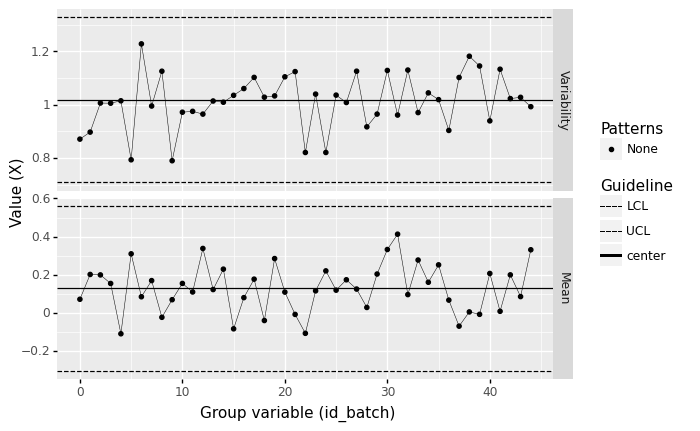

<ggplot: (8742559893110)>

In [8]:
%%capture --no-display
## TODO: Batch by consecutive rows, create a control chart
(
    df_time
# solution-begin    
    >> gr.tf_mutate(id_batch=DF.index // 50)
    >> gr.pt_xbs(group="id_batch", var="X")
# solution-end    
)

*Observations*

- What is the correct group size, based on how the data were generated?
  - The correct batch size if `n=50`.
- Based on the batch size you chose, did you find any out-of-control patterns?
  - At a batch size of `n=50` I did not find any out-of-control patterns.
- If you answered "yes" to the previous question, does your group variable give you a meaningful way to determine what may have cause the out-of-control pattern?
  - NA
<!-- solution-end -->

### __qX__ Batch by slices of time

Sort the data by time `t`, then batch the observations into consecutive groups and construct a control chart. 

Make sure to *match* the group size used in data collection.

Answer the questions under *observations* below.


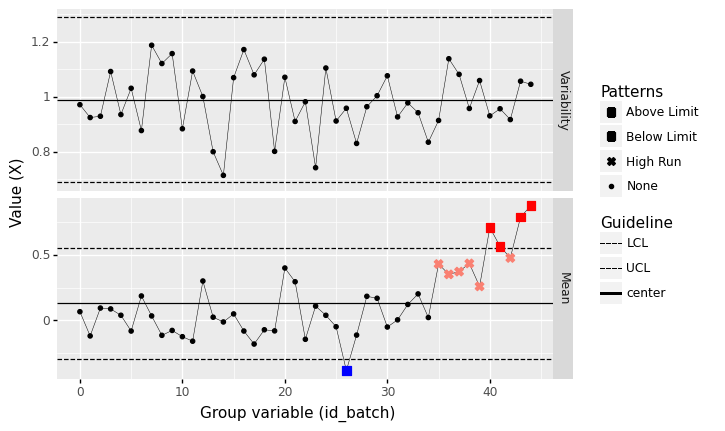

<ggplot: (8742560480178)>

In [9]:
%%capture --no-display
## TODO: Arrange the dataset by time `t`, then batch and plot
# a control chart
(
    df_time
# solution-begin    
    >> gr.tf_arrange(DF.t)
    >> gr.tf_mutate(id_batch=DF.index // 50)
    >> gr.pt_xbs(group="id_batch", var="X")
# solution-end    
)

*Observations*

- Based on the batch size you chose, did you find any out-of-control patterns?
  - Arranged by time and with a batch size of `n=50`, I find one case of excessive variability, one low mean, and a long string of high-mean .
- If you answered "yes" to the previous question, does your group variable give you a meaningful way to determine what may have cause the out-of-control pattern?
  - Yes; since the batches are arranged in time, we can see that the process was trending upward in time towards the end of the period.
<!-- solution-end -->

# Patterns to seek

Kenett and Zacks (2014) highlight several patterns that can signal an out-of-control manufacturing process:

> 1. A single point outside the control limits.
> 2. A run of nine or more points in a row above (or below) the centerline.
> 3. Six consecutive points increasing (trend up) or decreasing (trend down).

The following cells simulate data to illustrate each of these patterns.


## Outside control limits

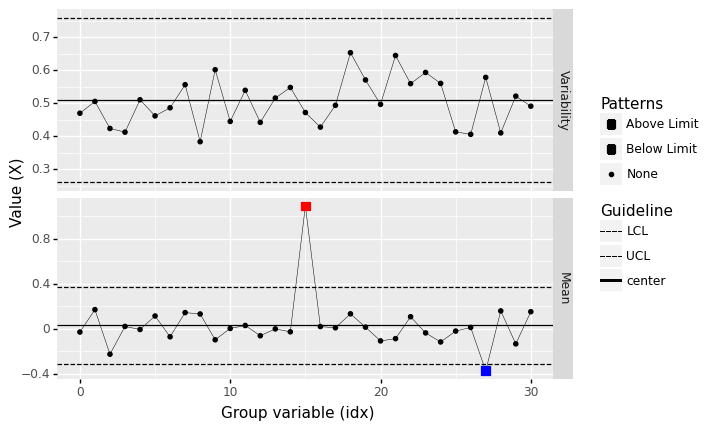

<ggplot: (8742551482877)>

In [10]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*15 + [1]*1 + [0]*15 
mg_standard = gr.marg_mom("norm", mean=0, sd=0.5)

df_outlier = gr.df_grid()
for i, m in enumerate(mu):
    df_outlier = (
        df_outlier
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_outlier
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Variability out-of-control


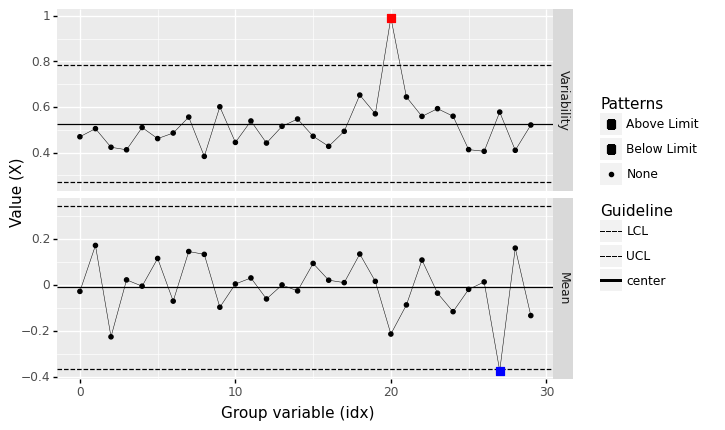

<ggplot: (8742551393922)>

In [11]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*30
mg_standard = gr.marg_mom("norm", mean=0, sd=0.5)

df_outlier = gr.df_grid()
for i, m in enumerate(mu):
    df_outlier = (
        df_outlier
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) * (1 + (i == 20)) + m
        ))
    )
    
(
    df_outlier
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Runs above center

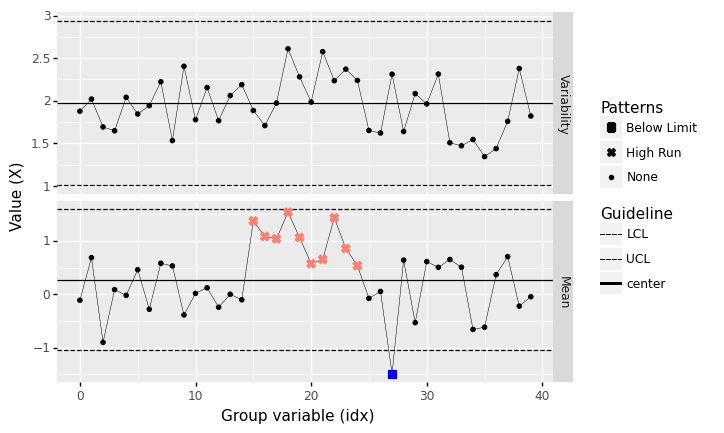

<ggplot: (8742551411637)>

In [12]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*15 + [1]*10 + [0]*15 
mg_standard = gr.marg_mom("norm", mean=0, sd=2.0)

df_above = gr.df_grid()
for i, m in enumerate(mu):
    df_above = (
        df_above
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_above
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

Note that none of the observations exceed the upper control limit (UCL), but a "run" of many (9 or more) observations above the centerline is highly unlikely to be due to chance alone. 


## Runs below center


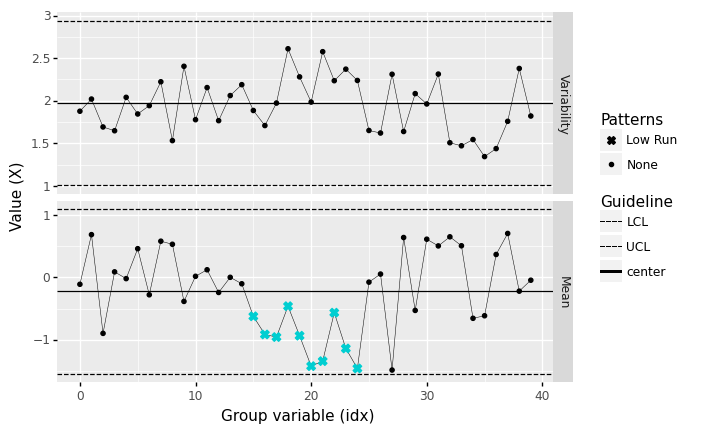

<ggplot: (8742560248019)>

In [13]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*15 + [-1]*10 + [0]*15 
mg_standard = gr.marg_mom("norm", mean=0, sd=2.0)

df_below = gr.df_grid()
for i, m in enumerate(mu):
    df_below = (
        df_below
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_below
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Runs increasing


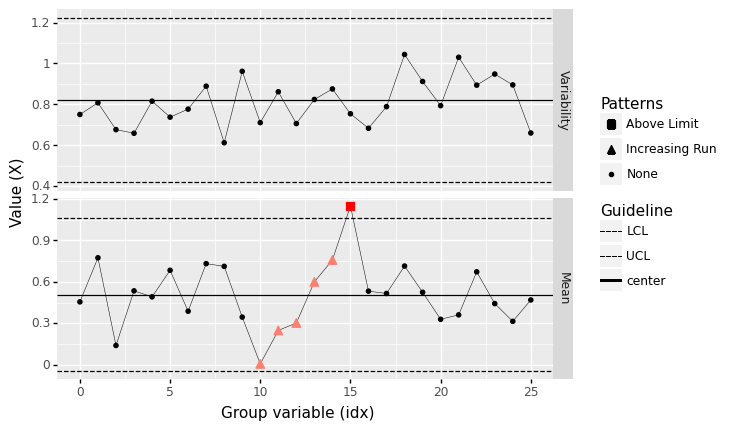

<ggplot: (8742560018092)>

In [14]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0.5]*10 + list(gr.linspace(0, 1, 6)) + [0.5]*10
mg_standard = gr.marg_mom("norm", mean=0, sd=0.8)

df_increase = gr.df_grid()
for i, m in enumerate(mu):
    df_increase = (
        df_increase
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_increase
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Runs decreasing


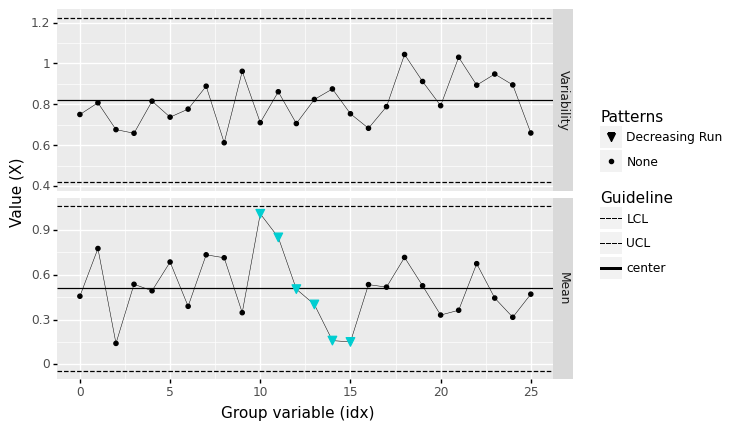

<ggplot: (8742560933955)>

In [15]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0.5]*10 + list(1 - gr.linspace(0, 1, 6)) + [0.5]*10
mg_standard = gr.marg_mom("norm", mean=0, sd=0.8)

df_decrease = gr.df_grid()
for i, m in enumerate(mu):
    df_decrease = (
        df_decrease
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_decrease
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

# Warnings


## Beware spurious patterns!

Note that *false patterns* can still occur based on random events. These false patterns become more likely with smaller batch sizes. For instance, let's take a look at the completely random dataset from above, batched into tiny subgroups:


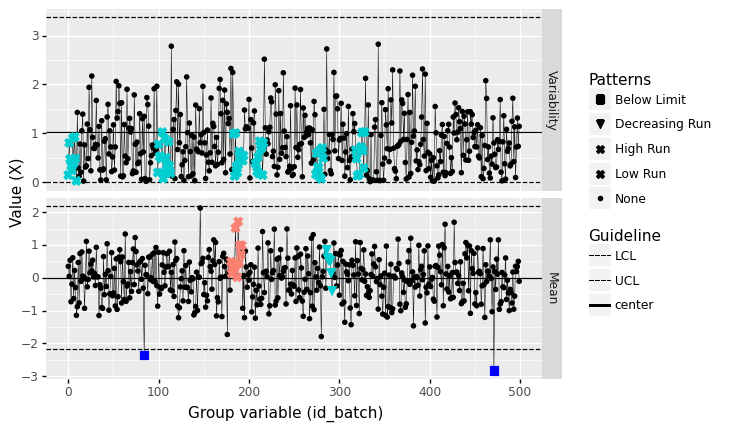

<ggplot: (8742551064287)>

In [16]:
%%capture --no-display
## NOTE: No need to edit

(
    df_random 
    >> gr.tf_mutate(id_batch=DF.index // 2)
    >> gr.pt_xbs(group="id_batch", var="X")
)

Note that a variety of "patterns" are detected, but these cannot possibly be due to any assignable causes: The data are completely random by construction. Using a larger batch size helps to protect us against being mislead by random patterns, but keep in mind that false detections are always possible!


## Beware meaningless order

Patterns based on order (such as high/low or increasing/decreasing runs) are meaningless when order of the group variable has no meaning. For instance, we can reorder the machine identifiers in `df_machines` to artificially create an increasing run:


/home/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/home/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/home/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/home/zach/Git/py_grama/grama/dfply/vector.py:122: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
/home/zach/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

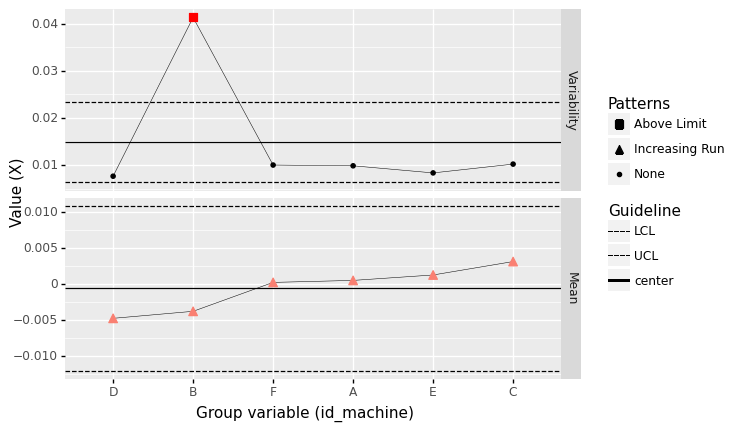

<ggplot: (8742560148827)>

In [17]:
(
    df_machines
    >> gr.tf_mutate(id_machine=gr.fct_reorder(DF.id_machine, DF.X, fun=gr.mean))
    >> gr.pt_xbs(group="id_machine", var="X")
)

# Example: Cast Aluminum Dataset


In [18]:
from grama.data import df_shewhart
df_shewhart.head()

,specimen,tensile_strength,hardness,density
0,1,29314,53.0,2.666
1,2,34860,70.2,2.708
2,3,36818,84.3,2.865
3,4,30120,55.3,2.627
4,5,34020,78.5,2.581


### __qX__ Assess the `density`

Assess the state of statistical control for the variable `density` using a control chart.

Answer the questions under *observations* below.


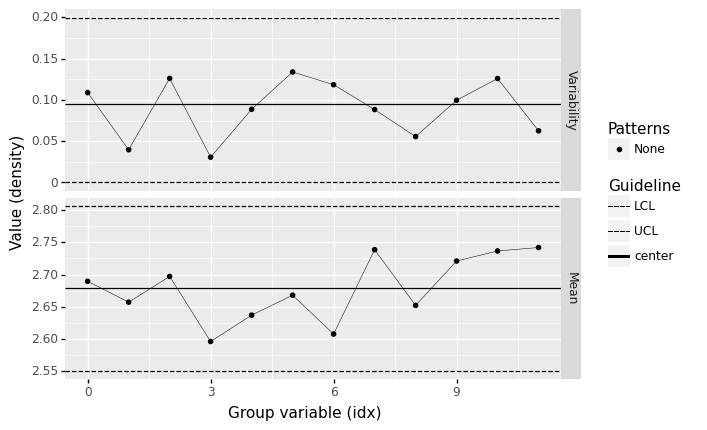

<ggplot: (8742550997767)>

In [19]:
%%capture --no-display
## TODO: Construct batches and make a control chart
(
    df_shewhart
    >> gr.tf_mutate(idx=DF.index // 5)
    >> gr.pt_xbs(group="idx", var="density")
)


*Observations*

- What *assumptions* did you have to make in order to construct rational batches?
  - To group observations into consecutive batches, we need to assume that the data are reported in the order they were collected.
- Based on the batch size you chose, did you find any out-of-control patterns? Did it occur in the `Variability` or batch `Mean`?
  - No; I found no out-of-control patterns.
- If you answered "yes" to the previous question: Based on the batch size you chose, are those patterns likely to be spurious?
  - NA
- Is the `density` likely to be under statistical control?
  - Yes; I find no evidence of out-of-control behavior.
<!-- solution-end -->

### __qX__ Assess the `tensile_strength`

Assess the state of statistical control for the variable `tensile_strength` using a control chart.

Answer the questions under *observations* below.


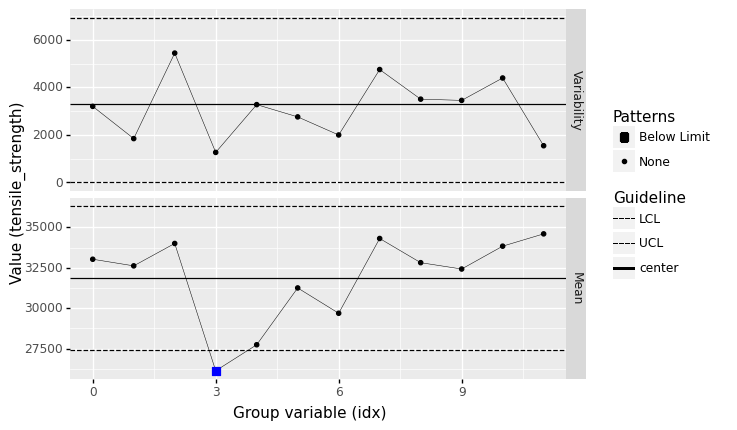

<ggplot: (8742550940715)>

In [20]:
%%capture --no-display
## TODO: Construct batches and make a control chart
(
    df_shewhart
    >> gr.tf_mutate(idx=DF.index // 5)
    >> gr.pt_xbs(group="idx", var="tensile_strength")
)


*Observations*

- What *assumptions* did you have to make in order to construct rational batches?
  - To group observations into consecutive batches, we need to assume that the data are reported in the order they were collected.
- Based on the batch size you chose, did you find any out-of-control patterns? Did it occur in the `Variability` or batch `Mean`?
  - Yes; at a batch size of `n=5` I found the mean to violate the LCL.
- If you answered "yes" to the previous question: Based on the batch size you chose, are those patterns likely to be spurious?
  - Possibly; `n=5` is a very small batch size, so this could certainly be due to chance.
- Is the `tensile_strength` likely to be under statistical control?
  - Possibly; I find that the below LCL batch mean persists for batch sizes of `n=6,7,8,9`, which suggests the process may have been out of control for some of the earlier runs. However, the below LCL case disappears for `n=10`; it is possible that this pattern is spurious.
<!-- solution-end -->

# References

- Kenett and Zacks, *Modern Industrial Statistics*, 2nd Edition (2014)
